# CSE 402 Final Project

## MobileNetV2 

### Imports

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import torchvision.models as models
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.datasets import load_sample_image
import numpy as np
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torchvision
from torchvision import transforms
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

### Data Loading and Preprocessing

In [79]:

directory = '/Users/ethandemott/Documents/cse402/project/Celebrity Faces Dataset'

# Define image transformation for MobileNetV2
target_size = (224, 224)  # Required size for MobileNetV2
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load images and labels
images, labels = [], []
for root, _, files in os.walk(directory):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            image = Image.open(image_path).convert('RGB')
            images.append(transform(image))
            labels.append(os.path.basename(root))  # Label is folder name

# Convert lists to tensors
images_tensor = torch.stack(images)
label_encoder = LabelEncoder()
labels_encoded = torch.tensor(label_encoder.fit_transform(labels))

# Setup the MobileNetV2 model
num_classes = len(label_encoder.classes_)
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)  # Adjust for your classes
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /Users/ethandemott/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 30.8MB/s]


### Model Training

In [85]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# store predictions for a confusion matrix
all_predictions = []
all_true_labels = []

# Cross-validation loop
for fold, (train_idx, test_idx) in enumerate(kf.split(images_tensor)):
    print(f'Fold {fold + 1}')

    train_subset = Subset(TensorDataset(images_tensor, labels_encoded), train_idx)
    test_subset = Subset(TensorDataset(images_tensor, labels_encoded), test_idx)

    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=16, shuffle=False)

    model.train()
    for epoch in range(10):  # Adjust number of epochs as needed
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

    # Evaluate on the test set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
 
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(targets.cpu().numpy())

    print(f'Fold {fold + 1} Accuracy: {correct / total:.4f}')

overall_accuracy = sum(np.array(all_predictions) == np.array(all_true_labels)) / len(all_true_labels)
print(f'Overall Cross-Validation Accuracy: {overall_accuracy:.4f}')

Fold 1
Epoch 1, Loss: 0.15600513978906924
Epoch 2, Loss: 0.09583116343642092
Epoch 3, Loss: 0.049195285403602254
Epoch 4, Loss: 0.0341256025500365
Epoch 5, Loss: 0.014461471022442827
Epoch 6, Loss: 0.016301551392911385
Epoch 7, Loss: 0.031084667607216284
Epoch 8, Loss: 0.012227696820677831
Epoch 9, Loss: 0.004520962219867572
Epoch 10, Loss: 0.004360364311954375
Fold 1 Accuracy: 1.0000
Fold 2
Epoch 1, Loss: 0.007790929162816681
Epoch 2, Loss: 0.0028303867959895046
Epoch 3, Loss: 0.014994948870284418
Epoch 4, Loss: 0.1128241175622451
Epoch 5, Loss: 0.17640195394907257
Epoch 6, Loss: 0.12343030341206958
Epoch 7, Loss: 0.01745924653026604
Epoch 8, Loss: 0.023725980186938223
Epoch 9, Loss: 0.03164801121951599
Epoch 10, Loss: 0.07501502631474104
Fold 2 Accuracy: 0.9667
Fold 3
Epoch 1, Loss: 0.0967908204483512
Epoch 2, Loss: 0.0784232323719919
Epoch 3, Loss: 0.047427305144297216
Epoch 4, Loss: 0.044808487489111336
Epoch 5, Loss: 0.07443362472330074
Epoch 6, Loss: 0.041277319943308646
Epoch 7,

### Confusion Matrix

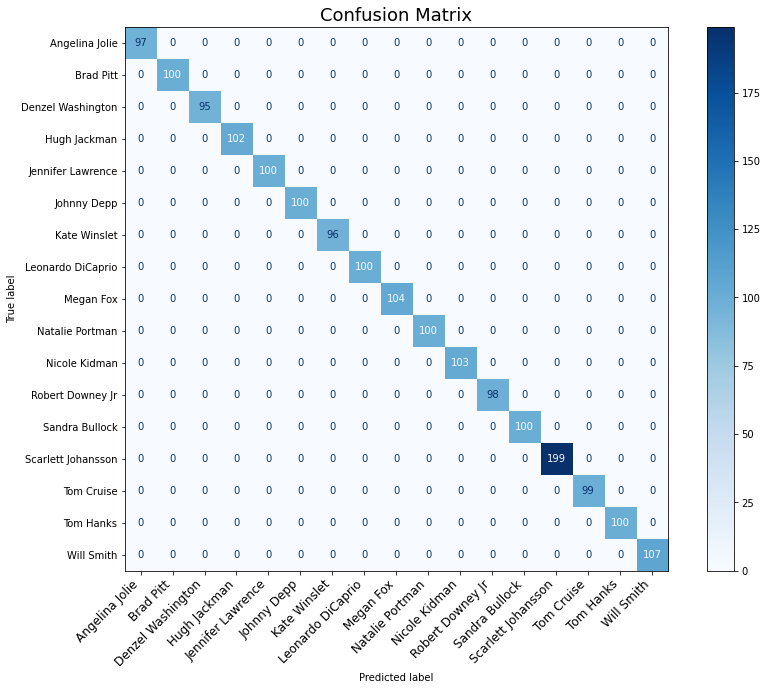

In [117]:
cm = confusion_matrix(all_predictions, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(14, 10))  
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12) 

plt.title("Confusion Matrix", fontsize=18)
plt.show()

In [101]:
torch.save(model.state_dict(), 'trained_model.pth')
